# Exploratory Analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# df = pd.read_csv('/kaggle/input/duke-cs671-fall21-airbnb-availability-data/train.csv')
# test_df = pd.read_csv('/kaggle/input/duke-cs671-fall21-airbnb-availability-data/test.csv')

# If doing this on your machine...
df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

## Basic information about the dataset
Number of rows: 7471

In [2]:
print(df.columns)

Index(['id', 'Decision', 'Host_response_time', 'Host_is_superhost',
       'Host_has_profile_pic', 'Host_identity_verified', 'Neighbourhood',
       'Property_type', 'Room_type', 'Accommodates', 'Bathrooms_text',
       'Bedrooms', 'Beds', 'Essentials', 'Cooking', 'Balcony', 'Parking',
       'Price', 'Number_of_reviews', 'Review_scores_rating',
       'Instant_bookable', 'Month'],
      dtype='object')


In [3]:
# Let's look at categorical variables to start...how should we encode?
cat_vars = df.columns[df.dtypes=='object']
print(cat_vars)

Index(['Host_response_time', 'Host_is_superhost', 'Host_has_profile_pic',
       'Host_identity_verified', 'Property_type', 'Room_type',
       'Bathrooms_text', 'Price', 'Instant_bookable', 'Month'],
      dtype='object')


Out of all of these, it looks like all of these columns except for "Price" should be encoded. Let's look at what the encodings should be.



In [4]:
for cat in cat_vars.drop("Price"):
    print(cat)
    print(set(df[cat]))
    print("----")

Host_response_time
{nan, 'within a day', 'within a few hours', 'a few days or more', 'within an hour'}
----
Host_is_superhost
{nan, 't', 'f'}
----
Host_has_profile_pic
{nan, 't', 'f'}
----
Host_identity_verified
{nan, 't', 'f'}
----
Property_type
{'Private room in house', 'Shared room in rental unit', 'Entire apartment', 'Private room', 'Entire residential home', 'Entire condominium', 'Private room in residential home', 'Entire guesthouse', 'Room in bed and breakfast', 'Farm stay', 'Private room in condominium (condo)', 'Room in boutique hotel', 'Private room in condominium', 'Yurt', 'Entire cabin', 'Private room in bungalow', 'Entire chalet', 'Private room in cabin', 'Private room in hostel', 'Shipping container', 'Entire rental unit', 'Private room in townhouse', 'Entire house', 'Private room in hut', 'Camper/RV', 'Shared room in house', 'Shared room in hostel', 'Campsite', 'Casa particular (Cuba)', 'Entire place', 'Shared room in apartment', 'Casa particular', 'Private room in guest

OK -- looks like we have some interesting variables that are not uniform. The following transformations are going to be required:

#### Host_response_time
This encoding could be on a scale from 1 (quickest) to 4 (slowest). Using this scale will allow this column to be useful in any linear models that might be used (e.g., Logistic regression or SVM).
* within an hour -- 1
* within a few hours -- 2
* within a day -- 3
* a few days or more -- 4
* NaN or other -- 5 (this is required in the case that the test data doesn't map correctly)

#### Host_is_superhost, Host_has_profile_pic, Host_identity_verified, Instant_bookable
These are all boolean, so I will encode them as 0 (false) or 1 (true). If no value provided, then I will assume false for these values as well.

#### Property type
There is a lot of variation in this text, and it looks like the essential information is contained in other variables: the Room_type feature denotes whether the property is shared, prive, an entire home, or in a hotel, and the price will give some indication of the luxuriousness of the accommodation. However, there still is some information that might be useful here. Namely, I could see users looking for a "rustic" accommodation (one that is in the countryside or in a cabin), or a "special" accommodation (a non-traditional accommodation). This is relatively subjective, but I will create two boolean variables for these features, defined as follows:
* Rustic. 1 if description contains any of the following words: cabin, farm, yurt, tent, camp. 0 otherwise.
* Special. 1 if description contains any of the following words: camper, rv, tree, castle, bus,van. 0 otherwise.

I would expect that these features would make the locations less available, since they would be outside of normal accommodations.

#### Bathroom Texts
This text contains a number and information on whether the bathroom is shared. So this number will be extract as a feature, and the feature "shared" will be created as a boolean variable, with 1 indicating that the bathroom is shared (if the text contains "shared"), 0 otherwise.


#### Room Type
I will encode the room type based on the criteria below.
* Entire home/apt - 1
* Hotel room - 2
* Private room - 3
* Shared room - 4
* N/A - 5 (in the case that the value is not in this list)

**Depending on performance, it might be worth revisiting this encoding to determine whether dummy variables make more sense.**

#### Month
Months will be ordered from June to September, 1 to 4, since these 4 months are the only months included in the analysis.

**Before encoding, let's see how many columns are NA, indicating that they need to be removed.**

In [5]:
len(df[df.isnull().any(1)])

1605

So there are 1605 rows with at least one NA value in the dataset. If I were to guess, this is likely a function of the place being brand new to AirBnB (and therefore, lacking certain datapoints). 

In [6]:
print(len(df[df['Host_response_time'].isnull()]))

858


In [7]:
import re
def map_data(data):
    """
    This function converts the data to the target format so that it can be processed in the ML
    model.
    
    """
    
    # Make a new copy...since we want to return a new version of
    # the data, rather than overwrite the existing version of the
    # data.
    new_df = data.copy()
    
    ## Deal with host response time.
    host_response_time_map = {
        "within an hour": 1,
        "within a few hours": 2,
        "within a day": 3,
        "a few days or more": 4
    }
    new_df['Host_response_time'] = list(map(lambda x: host_response_time_map[x] if x in host_response_time_map else 5, data['Host_response_time']))
    
    ## Deal with boolean variables
    bool_vars = ['Host_is_superhost', 'Host_has_profile_pic', 'Host_identity_verified', 'Instant_bookable']
    
    for bv in bool_vars:
        new_df[bv] = list(map(lambda x: 1 if x=='t' else 0, data[bv]))
    
    ## Property type
    def is_rustic(val):
        if(re.search(r'camp|farm|yurt|tent|cabin',val) is None):
            return 0
        return 1
    
    new_df['rustic'] = list(map(is_rustic, new_df['Property_type']))
    
    def is_special(val):
        if(re.search(r'camper|rv|tree|castle|bus|van', val) is None):
            return 0
        return 1
    
    new_df['special'] = list(map(is_special, new_df['Property_type']))
    
    
    ## Bathroom text
    def extract_num(val):
        num = re.match(r'[\d|.]+', val)
        if (num is None):
            return 0 # Assume no number found...so no baths
        return float(num[0])
    
    new_df['num_baths'] = list(map(extract_num, new_df['Bathrooms_text']))
    
    def bath_is_shared(val):
        if (re.search(r'shared', val) is None):
            return 0
        return 1
    
    new_df['bath_is_shared'] = list(map(bath_is_shared, new_df['Bathrooms_text']))
    
    
    ## Room type
    
    room_type_map = {
        "Entire home/apt": 1,
        "Hotel room": 2,
        "Private room": 3,
        "Shared room": 4
    }
    new_df['Room_type'] = list(map(lambda x: room_type_map[x] if x in room_type_map else 5, data['Room_type']))
    ## Month
    month_map = {
        "June": 6,
        "July": 7,
        "August": 8,
        "September": 9
    }
    new_df['Month'] = list(map(lambda x: month_map[x] if x in room_type_map else 0, data['Month']))

    # There are bedrooms with null values, let's set NULL to 0 so that
    # we can turn that value into something meaningful.
    new_df['Bedrooms'] = data['Bedrooms'].fillna(0)
    
    ## Price needs to be converted to a number, too.
    new_df["Price"] = [re.search(r'\d+', val)[0] for val in data["Price"]]
    
    ## If there are no ratings, a special value of -1 is applied. 
    new_df['Review_scores_rating'] = data['Review_scores_rating'].fillna(-1)
    
    # If there are no beds included (NaN), then replace with zero.
    new_df['Beds'] = data['Beds'].fillna(0)
    new_df = new_df.drop(columns="id")
    ## Return this new DataFrame without the columns that
    # were replaced through this map.
    return new_df.drop(columns=['Property_type','Bathrooms_text'])

nd = map_data(df)
nd.head()

Decision  Host_response_time  Host_is_superhost  Host_has_profile_pic  \
0         1                   1                  1                     1   
1         1                   1                  1                     1   
2         0                   2                  1                     1   
3         1                   1                  1                     1   
4         0                   1                  1                     1   

   Host_identity_verified  Neighbourhood  Room_type  Accommodates  Bedrooms  \
0                       1          28806          1             6       3.0   
1                       1          28804          1             4       1.0   
2                       1          28806          3             1       1.0   
3                       1          28803          1             8       2.0   
4                       1          28805          1             6       3.0   

   Beds  ...  Parking  Price  Number_of_reviews  Review_scores_rating  \
0   3.0  ...        1    164                 90                  4.93   
1   1.0  ...        1    101                522                  4.69   
2   1.0  ...        1     32                 35                  4.83   
3   5.0  ...        1    381                 11                  5.00   
4   4.0  ...        1    238                 63                  4.70   

  Instant_bookable  Month  rustic  special  num_baths  bath_is_shared  
0                1      0       1        0        1.0               0  
1                1      0       0        0        1.0               0  
2                0      0       0        0        1.0               0  
3                1      0       0        0        2.0               0  
4                0      0       0        0        2.0               0  

[5 rows x 23 columns]

# Exploratory Analysis

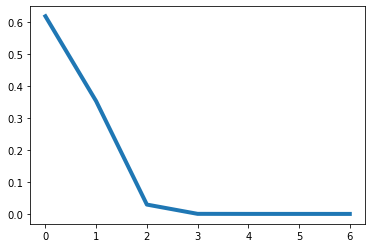

In [8]:
# Let's see if we can use PCA to determine clusters.
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=7)

pca.fit(nd.drop(columns=["Decision"]))
plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),lw=4)

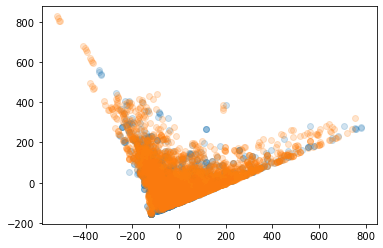

In [9]:
nd_avail = pca.transform(nd[nd["Decision"]==0].drop(columns=["Decision"]))
plt.scatter(nd_avail[:,0],nd_avail[:,1],alpha=0.2)
nd_not_avail = pca.transform(nd[nd["Decision"]==1].drop(columns=["Decision"]))
plt.scatter(nd_not_avail[:,0],nd_not_avail[:,1],alpha=0.2)

Based on the above, it looks like the data's variance can be explained by primarily two principal components, and the data is mixed between these two, so I shouldn't expect that my models will be able to split the two very well.

(array([2736.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4735.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

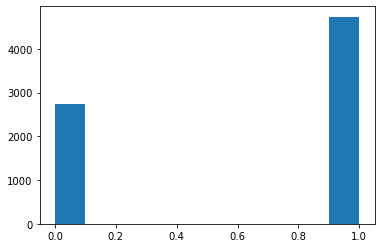

In [10]:
# Let's see how balanced the data is:
plt.hist(nd['Decision'])

In [11]:
print(f'Percent of decision 1 is {sum(nd["Decision"]/len(nd))}')
print(f"Percent of decision 0 is {1-sum(nd['Decision']/len(nd))}")

Percent of decision 1 is 0.6337839646633788
Percent of decision 0 is 0.36621603533662117


So, based on the above, we do NOT have balanced data -- we will want to make sure to consider this when training our model.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split up the training set...
x_train, x_test, y_train, y_test = train_test_split(nd.drop(columns="Decision"), nd["Decision"], test_size=0.2, random_state=1, stratify=nd["Decision"])


clf = RandomForestClassifier()

clf.fit(x_train, y_train)

RandomForestClassifier()

In [13]:
pred = clf.predict(x_train)

In [14]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, pred))
print(accuracy_score(y_train, pred))

[[2157   32]
 [  22 3765]]
0.9909638554216867


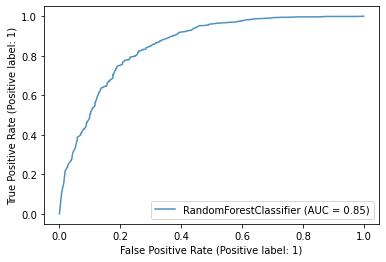

In [15]:
# Let's plot the ROC curve for this.
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(clf, x_test,y_test, ax=ax, alpha=0.8)
plt.show()

OK -- so my benchmark to beat is an AUC == 0.85. This is what I will try to improve on in future iterations!

In [16]:
test_pred = clf.predict(x_test)
print(confusion_matrix(y_test, test_pred))
print(accuracy_score(y_test, test_pred))

[[382 165]
 [141 807]]
0.7953177257525084


In [17]:
# Let's actually generate a prediction result to send in to kaggle.

def generate_file(test_ids, pred):
    submission = pd.DataFrame({
        'id':test_ids,
        'Decision': pred
    })
    
    submission.to_csv('../data/submission.csv', index=False)


In [18]:
# This is how I generate a test file
ids = test_df['id']

clean_test_data = map_data(test_df)

test_preds = clf.predict(clean_test_data)

generate_file(ids, test_preds)

### Optimizing Random Forest

In [52]:
# Let's consider the following hyperparameters:
n_estimators=[50,100,200,500]
max_depth=[2,5,10]
min_samples_split=[2, 5, 10, 20]
min_samples_leaf=[1,2,5]

In [23]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier()
scores = cross_val_score(clf,nd.drop(columns="Decision"), nd["Decision"], cv=5)
print(np.mean(scores))

0.8065841963170408


#### Looking at n_estimators

In [47]:
all_scores = []
for n_est in n_estimators:
    clf = RandomForestClassifier(n_estimators=n_est, oob_score=True)
    clf.fit(nd.drop(columns="Decision"), nd["Decision"])
#     scores = cross_val_score(clf,nd.drop(columns="Decision"), nd["Decision"], cv=5)
    all_scores.append(clf.oob_score_)
#     all_scores.append(np.mean(scores))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


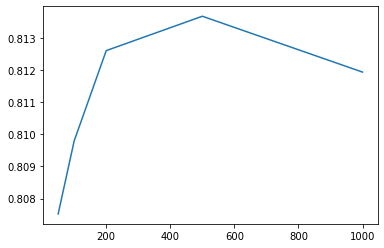

In [48]:
plt.plot(n_estimators, all_scores)

In [49]:
all_scores = []
n_estimators = [400,500, 600]
for n_est in n_estimators:
    clf = RandomForestClassifier(n_estimators=n_est, oob_score=True)
    clf.fit(nd.drop(columns="Decision"), nd["Decision"])
#     scores = cross_val_score(clf,nd.drop(columns="Decision"), nd["Decision"], cv=5)
    all_scores.append(clf.oob_score_)
#     all_scores.append(np.mean(scores))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


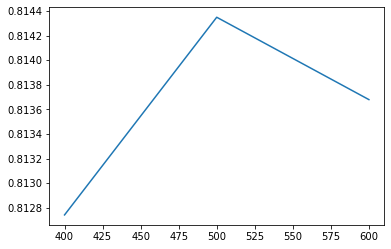

In [50]:
plt.plot(n_estimators, all_scores)

So, independent of using all other features, n_estimators=500 has the best results. Note, this might change if using other features, so let's train on multiple combinations of these features.

In [56]:
import itertools
arg_arr = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
combo = itertools.product(*arg_arr)
print(len(list(combo)))

144


In [ ]:
# TODO - run this on the GPU...this is expected to take a while.
all_scores = []
for c in combo:
    clf = RandomForestClassifier(random_state = 1, 
                                oob_score = True, 
                                n_estimators = c[0],
                                max_depth = c[1],
                                min_samples_split=c[2],
                                min_samples_leaf=c[3])
    clf.fit(nd.drop(columns="Decision"), nd["Decision"])
    all_scores.append(clf.oob_score_)
    

In [34]:
# So, based on the graph above, the optimal number of estimators is going to be 
# in the ballpark of 200. Let's refine what values we are looking at:
n_estimators = np.arange(170, 230, 5)

In [57]:
all_scores = []
import datetime

begin = datetime.datetime.now()
for n_est in n_estimators:
    clf = RandomForestClassifier(n_estimators=n_est, random_state=1)
    scores = cross_val_score(clf,nd.drop(columns="Decision"), nd["Decision"], cv=3)
    all_scores.append(scores)
print("Total run time:", datetime.datetime.now()-begin)

Total run time: 0:00:15.761955


In [36]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes(n_estimators)
 
# Creating plot
bp = ax.boxplot(all_scores)

TypeError: from_bounds() takes 4 positional arguments but 12 were given

<Figure size 720x504 with 0 Axes>

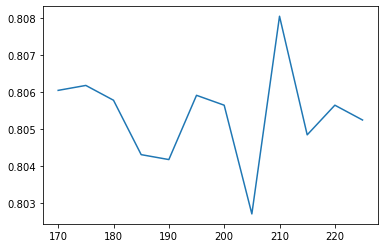

In [40]:
plt.plot(n_estimators, np.mean(all_scores, axis=1))

In [41]:
np.mean(all_scores, axis=1)

array([0.80604953, 0.80618322, 0.80578215, 0.8043087 , 0.80417527,
       0.80591566, 0.80564774, 0.80270334, 0.8080572 , 0.80484489,
       0.8056481 , 0.80524676])